### Authenticating with Hugging Face

In [ ]:
# ⬇️ Run this cell once
from ipywidgets import Password, Button, HBox, Output
import os, pathlib
import sys

from huggingface_hub import HfFolder, whoami

# ---- UI widgets ----
token_box = Password(
    description="HF Token:",
    placeholder="paste your Hugging Face token here",
    layout={"width": "450px"},
)
save_btn = Button(description="Save", button_style="success")
out = Output()

# ---- Callback ----
def save_token(_):
    out.clear_output()
    token = token_box.value.strip()
    with out:
        if not token:
            print("❌ No token entered.")
            return
        # Persist token
        HfFolder.save_token(token)                 # writes to ~/.cache/huggingface/token
        os.environ["HF_TOKEN"] = token             # current kernel env (optional)
        # Sanity-check who we are
        try:
            user = whoami(token)["name"]
            print(f"✅ Token saved. Logged in as: {user}")
        except Exception as e:
            print("⚠️ Token saved, but user lookup failed:", e)

save_btn.on_click(save_token)

display(HBox([token_box, save_btn]), out)

In [2]:
!pip install vllm

INFO: pip is looking at multiple versions of model-hosting-container-standards to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.5/466.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.0/355.0 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.0/183.0 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 130.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import torch
torch.cuda.is_available()

True

### Loading the model

For the experiments in this tutorial we will be using [nvidia/NVIDIA-Nemotron-Nano-9B-v2](https://huggingface.co/nvidia/NVIDIA-Nemotron-Nano-9B-v2), a large language model (LLM) trained from scratch by NVIDIA, and designed as a unified model for both reasoning and non-reasoning tasks.

In [1]:
from transformers import AutoTokenizer
from vllm import LLM, SamplingParams
import os

MODEL_ID = "nvidia/NVIDIA-Nemotron-Nano-9B-v2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)

tp = int(os.getenv("TP_SIZE", "1"))  # set >1 if you want tensor parallel across GPUs

llm = LLM(
    model=MODEL_ID,
    dtype="float16",
    trust_remote_code=True,
    tensor_parallel_size=tp,
    max_num_seqs=64,
    max_model_len=131072,
    mamba_ssm_cache_dtype="float32",
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/422 [00:00<?, ?B/s]

INFO 12-08 11:19:47 [utils.py:253] non-default args: {'trust_remote_code': True, 'dtype': 'float16', 'seed': None, 'max_model_len': 131072, 'max_num_seqs': 64, 'disable_log_stats': True, 'mamba_ssm_cache_dtype': 'float32', 'model': 'nvidia/NVIDIA-Nemotron-Nano-9B-v2'}


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


config.json: 0.00B [00:00, ?B/s]

WARNING 12-08 11:19:47 [arg_utils.py:1175] `seed=None` is equivalent to `seed=0` in V1 Engine. You will no longer be allowed to pass `None` in v0.13.


configuration_nemotron_h.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/NVIDIA-Nemotron-Nano-9B-v2:
- configuration_nemotron_h.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


INFO 12-08 11:20:08 [model.py:637] Resolved architecture: NemotronHForCausalLM
WARNING 12-08 11:20:08 [model.py:2089] Casting torch.bfloat16 to torch.float16.
INFO 12-08 11:20:08 [model.py:1750] Using max model len 131072
INFO 12-08 11:20:08 [scheduler.py:228] Chunked prefill is enabled with max_num_batched_tokens=8192.
INFO 12-08 11:20:08 [config.py:315] Disabling cascade attention since it is not supported for hybrid models.
INFO 12-08 11:20:08 [config.py:439] Setting attention block size to 1312 tokens to ensure that attention page size is >= mamba page size.
INFO 12-08 11:20:08 [config.py:463] Padding mamba page size by 1.08% to ensure that mamba page size and attention page size are exactly equal.


generation_config.json:   0%|          | 0.00/158 [00:00<?, ?B/s]

WARNING 12-08 11:20:10 [system_utils.py:136] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. See https://docs.vllm.ai/en/latest/usage/troubleshooting.html#python-multiprocessing for more information. Reasons: CUDA is initialized
INFO 12-08 11:22:26 [llm.py:343] Supported tasks: ['generate']


In [2]:
sampling = SamplingParams(
    max_tokens=512, temperature=0.7, top_p=0.9
)

### Convertng user prompts to chat

Modern LLMs often use role-tagged messages to structure conversations, where each entry specifies both a role (such as `system`, `user`, or `assistant`) and the `content` of the message. This format helps the model distinguish between instructions, user inputs, and its own prior outputs, enabling more consistent and controllable behavior. The system role typically sets context or constraints (e.g., tone, style, or reasoning mode), the user role provides queries or prompts, and the assistant role represents the model’s responses. By encoding dialogue this way, developers can guide multi-turn interactions, support features like reasoning toggles, and make model behavior easier to align across different applications.

The following helper function will be used to convert a list of role-tagged messages (e.g., system, user) into the exact chat prompt format expected by the **Nemotron Nano 9b v2 model**. It uses the tokenizer’s built-in chat template to render the conversation into text, appends a reasoning marker so the model knows it should reason or not, and outputs the result as a PyTorch tensor ready for inference.

In this fundamentals course, we will keep reasoning off for simplicity.

In [3]:
def to_chat(messages):
    """
    messages = [
      {"role": "system", "content": "/no_think"},   # or "/think"
      {"role": "user",   "content": "Write a haiku about GPUs"}
    ]
    """
    return tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        return_tensors="pt"
    )

## Executing inference with Nemotron Nano 9b v2

Now that the model is loaded, let’s run an inference example. Here we hardcode the user’s question — “Explain KV cache in one paragraph.” — inside the message list, along with a system instruction that disables reasoning (/no_think). When executed, the model will process the chat prompt and return its response, which we print below.

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import random
import string
from tqdm import tqdm

DISTANCES = [1000, 2000, 8000, 16000, 32000]
POSITIONS = ["middle", "start", "end"]

SECRET_FACT = "THE SECRET CODE IS 4711"
QUESTION = "What is the secret code?"
GROUND_TRUTH = "4711"


In [5]:
# Вспомогательная функция: генерирует случайный шум
def make_noise(n_tokens):
    # Просто генерируем n_tokens слов
    words = []
    for _ in range(n_tokens):
        w = ''.join(random.choices(string.ascii_lowercase, k=5))
        words.append(w)
    return " ".join(words)

In [6]:
def build_context(distance, position, fact):
    """Создаёт контекст, где секрет спрятан на указанной позиции."""
    noise_before = make_noise(distance // 2)
    noise_after = make_noise(distance // 2)

    if position == "start":
        context = f"{fact}\n{make_noise(distance)}"
    elif position == "middle":
        context = f"{noise_before}\n{fact}\n{noise_after}"
    elif position == "end":
        context = f"{make_noise(distance)}\n{fact}"
    else:
        raise ValueError("invalid position")

    return context

In [7]:
def ask_model(context, question):
    messages = [
        {"role": "system", "content": "/no_think"},
        {"role": "user",   "content": context + "\n\n" + question}
    ]
    chat_prompt = to_chat(messages)

    outs = llm.generate([chat_prompt], sampling)
    output = outs[0].outputs[0].text.strip()
    return output

def check_answer(output, truth):
    return truth.lower() in output.lower()

In [10]:
results = []
questions = [
    ("The secret code is 5999", "What is the secret code?", "5999"),
    ("The main ingredient in the recipe was Cardamom", "What is the main ingredient in the recipe?", "Cardamom"),
    ("The city where the summit took place was Rotterdam", "What city was chosen for the summit?", "Rotterdam"),
    ("A module with the id MX-3041 is missing", "What is the identifier of the missing module?", "MX-3041"),
    ("A restricted folger was marked with an amber tag", "What color tag marks the restricted folder?", "Amber"),
]

for pos in POSITIONS:
    for i, dist in enumerate(DISTANCES):
        context = build_context(dist, pos, questions[i][0])
        output = ask_model(context, questions[i][1])
        acc = 1 if check_answer(output, questions[i][2]) else 0

        results.append({
            "position": pos,
            "distance": dist,
            "accuracy": acc,
            "output": output,
        })

        print(f"[{pos}] {dist} tokens → acc={acc} | out={output[:60]}...")

df = pd.DataFrame(results)

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[middle] 1000 tokens → acc=1 | out=The secret code is **5999**, as explicitly stated in the inp...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[middle] 2000 tokens → acc=1 | out=The main ingredient in the recipe is **Cardamom**....


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[middle] 8000 tokens → acc=1 | out=The city chosen for the summit was **Rotterdam**....


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[middle] 16000 tokens → acc=0 | out=The...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[middle] 32000 tokens → acc=1 | out=The restricted folder is marked with an **amber tag**....


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[start] 1000 tokens → acc=1 | out=The secret code provided in your message is **5999**. This a...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[start] 2000 tokens → acc=1 | out=The main ingredient in the recipe is **Cardamom**....


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[start] 8000 tokens → acc=1 | out=The city chosen for the summit was **Rotterdam**....


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[start] 16000 tokens → acc=1 | out=The missing module's identifier is **MX-3041**, as stated in...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[start] 32000 tokens → acc=1 | out=The restricted folder is marked with an **amber** tag....


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[end] 1000 tokens → acc=1 | out=The secret code provided in the question is **5999**. 

Howe...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[end] 2000 tokens → acc=0 | out=The...


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[end] 8000 tokens → acc=1 | out=The city chosen for the summit was **Rotterdam**....


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[end] 16000 tokens → acc=1 | out=The identifier of the missing module is **MX-3041**....


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[end] 32000 tokens → acc=1 | out=The restricted folder is marked with an **amber** tag....


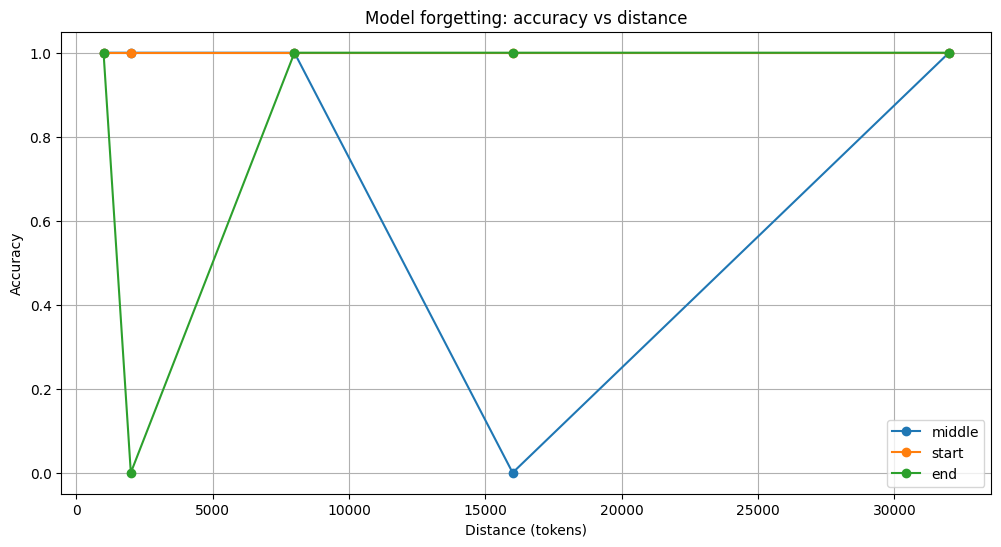


DONE. DF:
   position  distance  accuracy  \
0    middle      1000         1   
1    middle      2000         1   
2    middle      8000         1   
3    middle     16000         0   
4    middle     32000         1   
5     start      1000         1   
6     start      2000         1   
7     start      8000         1   
8     start     16000         1   
9     start     32000         1   
10      end      1000         1   
11      end      2000         0   
12      end      8000         1   
13      end     16000         1   
14      end     32000         1   

                                               output  
0   The secret code is **5999**, as explicitly sta...  
1   The main ingredient in the recipe is **Cardamo...  
2   The city chosen for the summit was **Rotterdam**.  
3                                                 The  
4   The restricted folder is marked with an **ambe...  
5   The secret code provided in your message is **...  
6   The main ingredient in the recip

In [11]:
plt.figure(figsize=(12, 6))

for pos in POSITIONS:
    sub = df[df["position"] == pos]
    plt.plot(sub["distance"], sub["accuracy"], marker="o", label=pos)

plt.xlabel("Distance (tokens)")
plt.ylabel("Accuracy")
plt.title("Model forgetting: accuracy vs distance")
plt.grid(True)
plt.legend()
plt.show()

print("\nDONE. DF:")
print(df)

## Stop this notebook

Make sure to restart the jupyter kernel before proceeding with next exercises.

In [ ]:
import os
os._exit(0)